## Notes:
Filtering with timeframe LDA doesn't affect anything

TODO:
- pre-whtening
- Canonical Correlation Analysis
- Bayesian LDA
- Common Average Reference
- TVLDA
- Look for outliars
- Neural network - DONE
- Augmentation - DONE

In [373]:
!pip install mne

You should consider upgrading via the '/home/malyshev/.pyenv/versions/3.9.2/envs/imagedl/bin/python3.9 -m pip install --upgrade pip' command.


In [375]:
import os
import numpy as np
import mne
from mne.externals.pymatreader import read_mat
import scipy.signal as sig
import matplotlib.pyplot as plt
import sys
sys.path.append('./non-mne/')

In [412]:
raw = read_mat(
    "/home/malyshev/Projects/hackthat-p300/data/S1.mat"
)
fs = 256
raw["info"] = mne.create_info(["1","2","3","4","5","6","7","8"], 250)

In [413]:
trig = raw['trig']
data = raw['y']

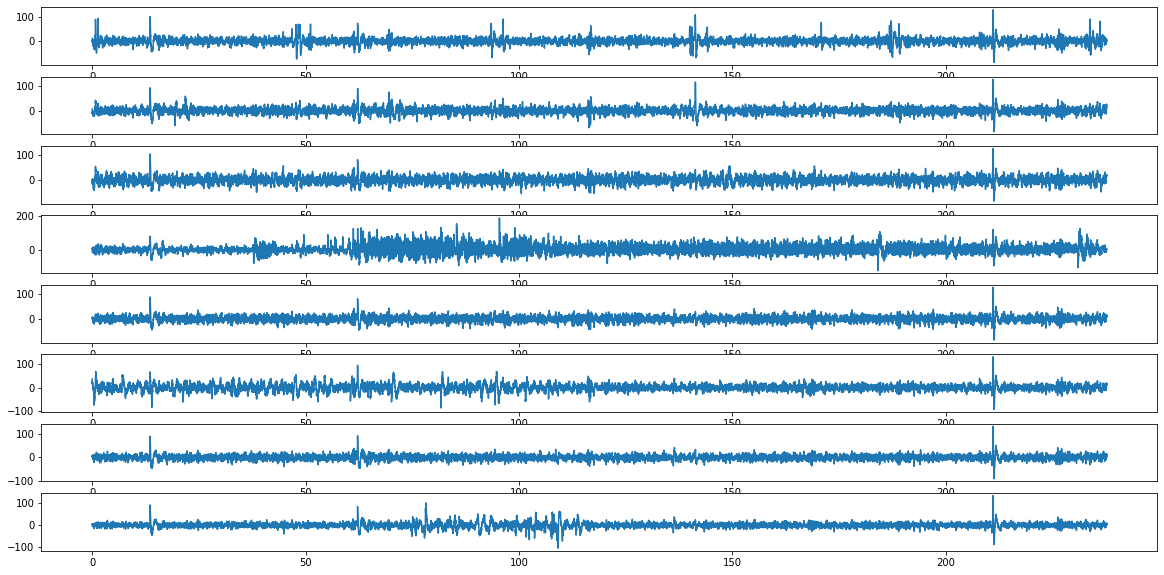

In [414]:
def plot_signal(signals: np.ndarray, sep=False):
    plt.figure(figsize=[20,10])
    N = signals.shape[0]
    for i in range(signals.shape[1]):
        if sep:
            plt.subplot(8,1,i+1)
        plt.plot(np.linspace(0,N/fs,N),signals[:,i])
    plt.show()

plot_signal(data, True)

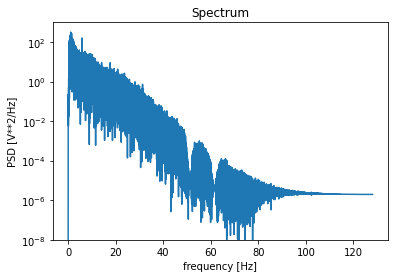

In [415]:
f, Pxx_den = sig.periodogram(data[:,0], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Spectrum')
plt.show()

## Filter and preview

In [416]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sig.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

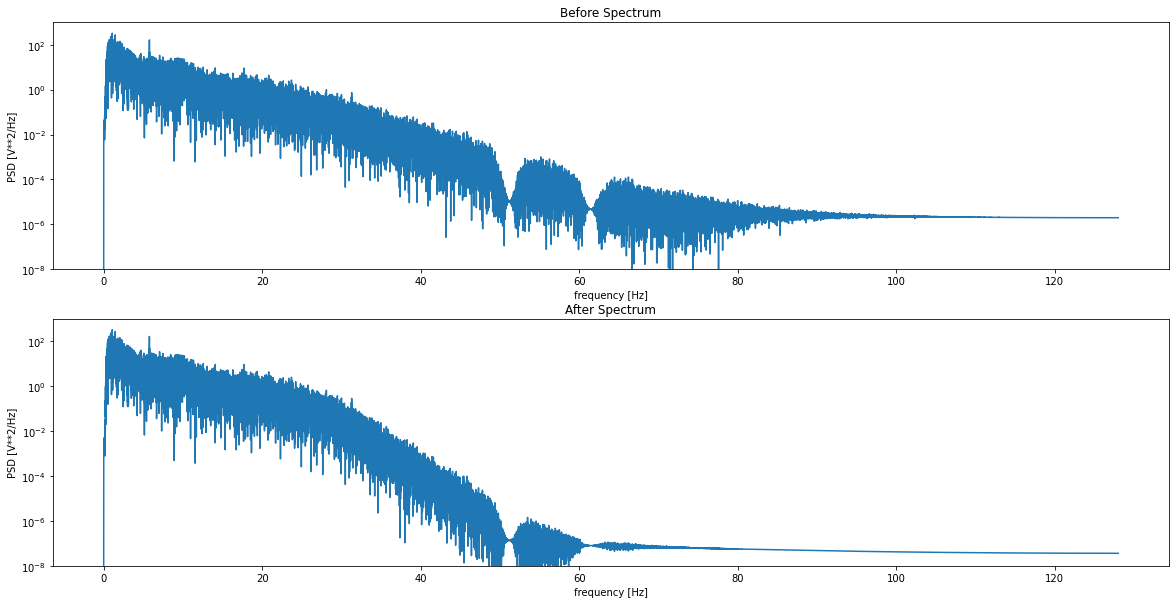

In [417]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.semilogy(*sig.periodogram(data[:,0], fs))
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Before Spectrum')


plt.subplot(2,1,2)
plt.semilogy(*sig.periodogram(butter_bandpass_filter(data[:,0],0.23,30,fs), fs))
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('After Spectrum')
plt.show()

[0.59534979 0.11426962 0.10472684 0.06704695 0.04482785 0.03964698
 0.02500931 0.00912265]


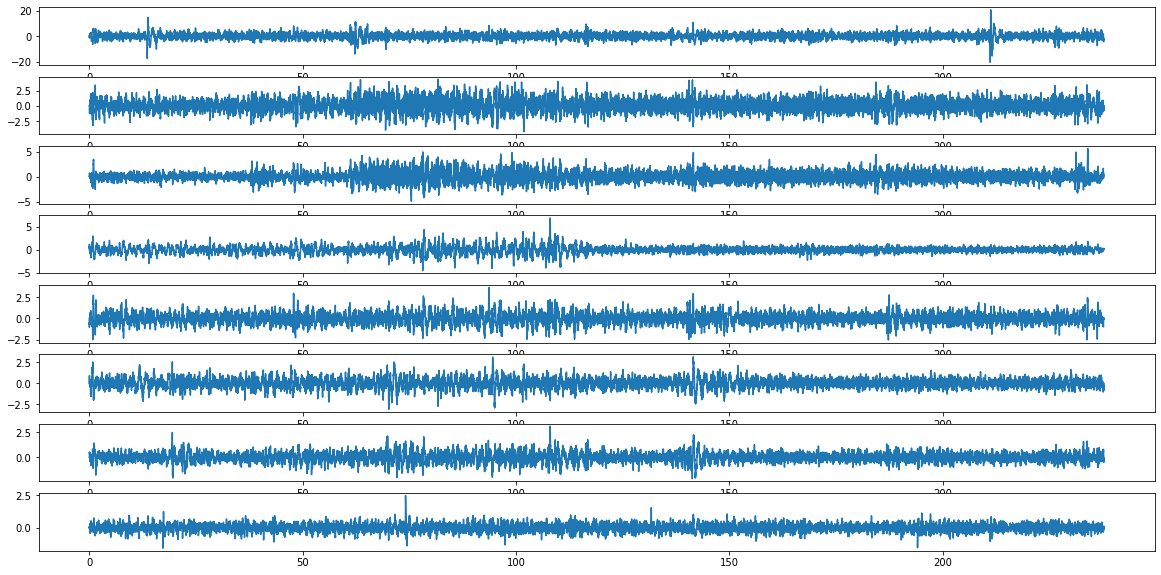

In [434]:
filtered = data.copy()
for i in range(filtered.shape[1]):
    filtered[:,i] = butter_bandpass_filter(data[:,i], 0.5, 30, fs)
    filtered[:,i] = np.convolve(filtered[:,i],7,'same')
filtered = (filtered - filtered.mean(0)[None]) / filtered.std(0)[None]
pca = PCA(8)
filtered = pca.fit_transform(filtered)
print(pca.explained_variance_ratio_)
plot_signal(filtered, True)

## Show near label

153


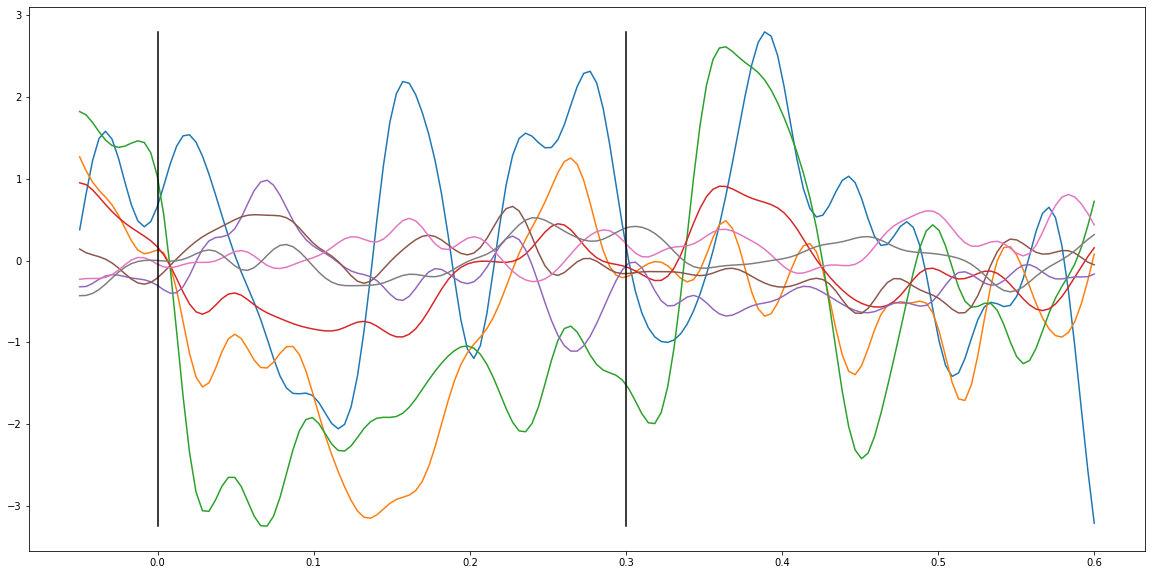

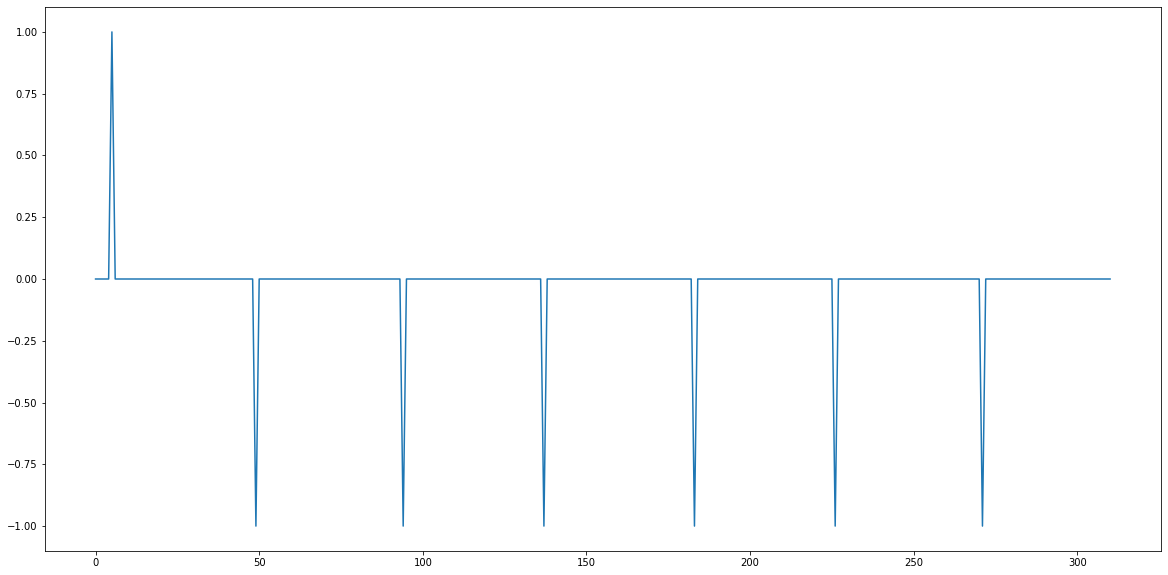

In [455]:
last = np.where(trig == 1)[0][-1]
p300 = int(0.6 * fs)
before = int(0.02 * fs)
print(p300)
plt.figure(figsize=(20,10))
sec = filtered[last-before:last + p300]
plt.plot(np.linspace(-0.05,0.3*2,sec.shape[0]),sec)
plt.plot([0.0]*2, [sec.min(), sec.max()], c='black')
plt.plot([0.3]*2, [sec.min(), sec.max()], c='black')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(trig[last-before:last + p300*2])
plt.show()

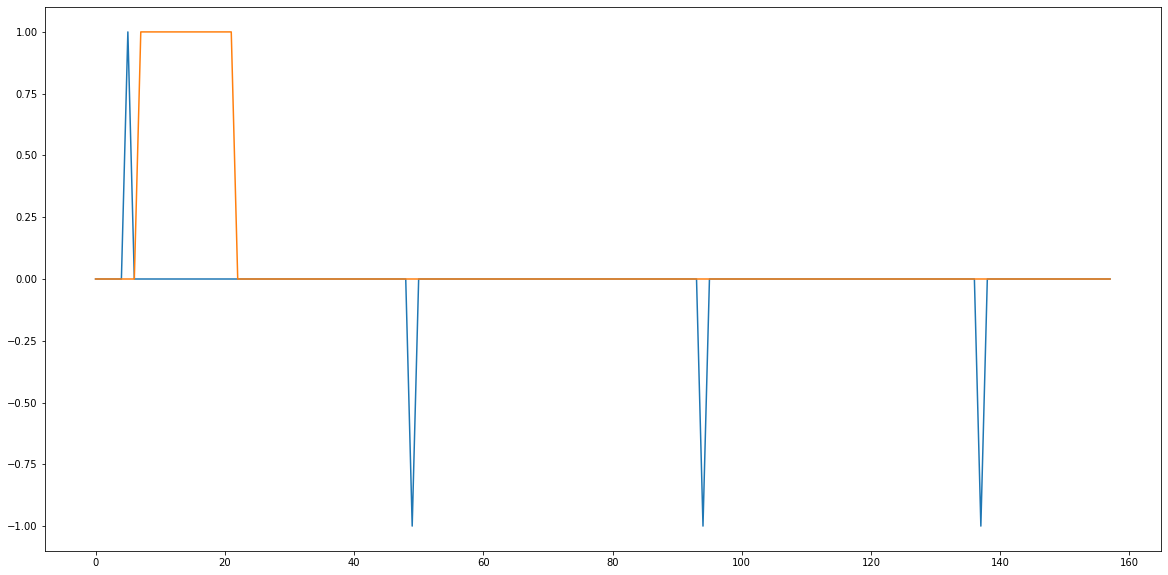

In [486]:
datavecs = []
for i in range(last-before, last+p300):
    datavecs.append(filtered[i-before:i + p300].reshape(1,-1))
plt.figure(figsize=(20,10))
plt.plot(trig[last-before:last + p300])
plt.plot(lda.predict(pca2.transform(np.concatenate(datavecs))))
plt.show()

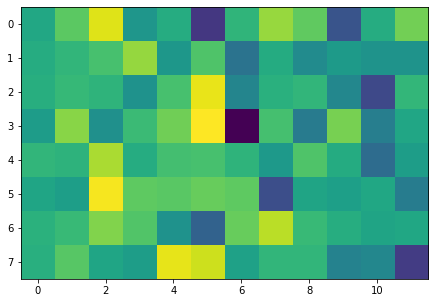

0.003857022679286979 0.11231210772716826


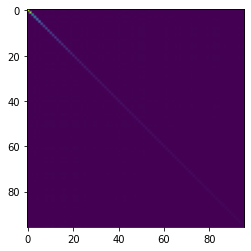

In [485]:
plt.figure(figsize=(20,5))
plt.imshow(lda.coef_.reshape(-1,8).T)
plt.show()
print(lda.coef_.mean(), lda.coef_.std())
plt.imshow(lda.covariance_)
plt.show()

### Classification

In [456]:
from sklearn.discriminant_analysis import *
from sklearn.decomposition import PCA

In [472]:
y = []
xs = []
for i in np.where(trig != 0)[0]:
    for j in np.linspace(-0.02*fs,0.02*fs,3, dtype=int):
        xs.append(filtered[i-before+j:i+p300+j])
        y.append((trig[i]+1) / 2)
y = np.array(y)
X = np.stack(xs)

exp_label = np.repeat(np.arange(0,5),240*3)
vs,cs = np.unique(y, return_counts=True)

# idxs = np.where(y==0)[0]
# np.random.shuffle(idxs)
# idxs = np.sort(np.concatenate([idxs[:cs.min()],np.where(y==1)[0]]))
# exp_label = exp_label[idxs]
# y = y[idxs]
# X = X[idxs]

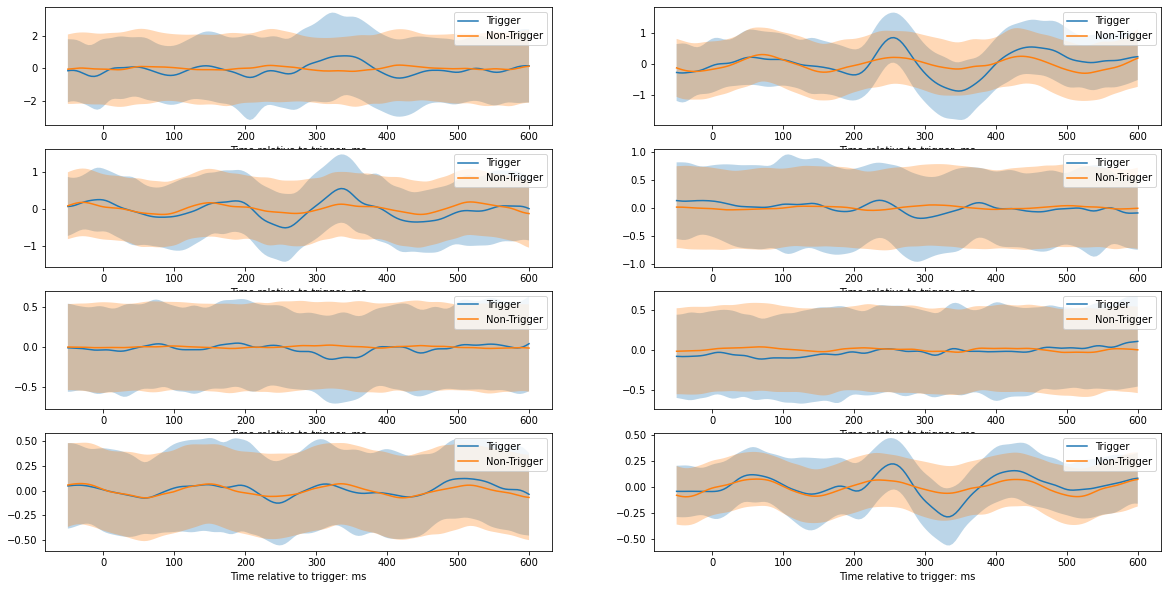

In [475]:
plt.figure(figsize=(20,10))
t = np.linspace(-50,600,X.shape[1])
for i in range(8):
    plt.subplot(4,2,i+1)
    mean = X[1::3][y[1::3]==1,:,i].mean(0)
    std = X[1::3][y[1::3]==1,:,i].std(0)
    plt.plot(t,mean, label='Trigger')
    plt.fill_between(t,mean-std, mean+std, alpha=0.3)
    mean = X[1::3][y[1::3]==0,:,i].mean(0)
    std = X[1::3][y[1::3]==0,:,i].std(0)
    plt.plot(t,mean, label='Non-Trigger')
    plt.fill_between(t,mean-std, mean+std, alpha=0.3)
    plt.legend()
    plt.xlabel('Time relative to trigger: ms')
plt.show()

0.9431432639553514
0.9441666666666667


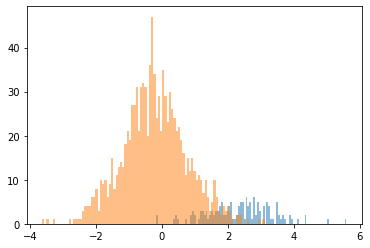

[[ 1.37571276e+02  2.08216316e-02  2.85069213e-02 ... -9.38382981e-03
  -8.83970782e-04 -2.00027715e-02]
 [ 2.08216316e-02  1.13064991e+02 -9.97496342e-03 ...  3.28353097e-03
   3.09313521e-04  6.99924457e-03]
 [ 2.85069213e-02 -9.97496342e-03  6.47125986e+01 ...  4.49548627e-03
   4.23481520e-04  9.58267430e-03]
 ...
 [-9.38382981e-03  3.28353097e-03  4.49548627e-03 ...  1.45400166e+00
  -1.39400480e-04 -3.15439832e-03]
 [-8.83970782e-04  3.09313521e-04  4.23481520e-04 ... -1.39400480e-04
   1.43072001e+00 -2.97149032e-04]
 [-2.00027715e-02  6.99924457e-03  9.58267430e-03 ... -3.15439832e-03
  -2.97149032e-04  1.38968064e+00]]


In [484]:
lda = LinearDiscriminantAnalysis(solver='svd', store_covariance=True)
X_flat = X.reshape(X.shape[0],-1)
pca2 = PCA(96)
X_flat = pca2.fit_transform(X_flat)
print(np.sum(pca2.explained_variance_ratio_))
lda.fit(X_flat, y)
res = lda.transform(X_flat[1::3])
print(lda.score(X_flat[1::3], y[1::3]))
plt.hist(res[y[1::3]==1],bins=100,alpha=0.5)
plt.hist(res[y[1::3]==0],bins=100,alpha=0.5)
plt.show()
print(lda.covariance_)

In [482]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
model = LinearDiscriminantAnalysis()

preds = []
for fold in range(5):
    print(f"FOLD {fold}")
    res = 0
    trX = X_flat[np.where(exp_label != fold)]
    valX = X_flat[np.where(exp_label == fold)]
    trY = y[np.where(exp_label != fold)]
    valY = y[np.where(exp_label == fold)]
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(trX, trY)
    trscore = lda.score(trX,trY)
    pred = lda.predict(valX)
    preds.append(pred)
    report = classification_report(valY, pred)
    print(report)
    score = lda.score(valX, valY)
    print(f'Training: {trscore:.4f} Validation: {score:.4f}')
    scores.append(score)
print('==============================')
print('FINAL')
print(classification_report(y, np.concatenate(preds)))

FOLD 0
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       630
         1.0       0.66      0.51      0.57        90

    accuracy                           0.91       720
   macro avg       0.79      0.74      0.76       720
weighted avg       0.90      0.91      0.90       720

Training: 0.9260 Validation: 0.9056
FOLD 1
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       630
         1.0       0.64      0.57      0.60        90

    accuracy                           0.91       720
   macro avg       0.79      0.76      0.77       720
weighted avg       0.90      0.91      0.90       720

Training: 0.9271 Validation: 0.9056
FOLD 2
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       630
         1.0       0.53      0.57      0.55        90

    accuracy                           0.88       720
   macro avg       0.73      0.75  

### Neural network

In [342]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [490]:
Xten = torch.tensor(X, dtype=torch.float32).transpose(1,2)
yten = torch.tensor(y)[...,None]

In [344]:
import sys
sys.path.append('/home/malyshev/Projects/Image_Analysis_DL')
from imagedl.nn.models.blocks import Mish
from imagedl.nn.optim import AdamP

In [349]:
def create_block(in_f, out_f, ker_size = 3, dropout=True):
    return nn.Sequential(
        nn.Conv1d(in_f,out_f,ker_size),
        nn.Dropout(p=0.3 if dropout else 0),
        Mish(),
        nn.BatchNorm1d(out_f)
    )

def create_net():
    return nn.Sequential(
        create_block(8,16, 3, False),
        create_block(16,32,5),
        nn.MaxPool1d(2),
        create_block(32,32,5),
        nn.MaxPool1d(2),
        create_block(32,32,3),
        nn.MaxPool1d(2),
        create_block(32,16,3),
        create_block(16,8,3),
        nn.MaxPool1d(2),
        create_block(8,8,3),
        nn.MaxPool1d(4),
        create_block(8,1,1, False),
        nn.Flatten(),
    )



In [ ]:
N = len(Xten)
K = N // 5

preds = []
for fold in range(5):
    print(f"FOLD {fold}")
    net = create_net()
    optim = AdamP(net.parameters())
    crit = nn.BCEWithLogitsLoss()
    res = 0
    train_Xten = TensorDataset(Xten[np.where(exp_label!=fold)])
    val_Xten = TensorDataset(Xten[np.where(exp_label==fold)])
    
    train_yten = TensorDataset(yten[np.where(exp_label!=fold)])
    val_yten = TensorDataset(yten[np.where(exp_label==fold)])

    txdl = DataLoader(train_Xten, batch_size=4)
    tydl = DataLoader(train_yten, batch_size=4)
    vxdl = DataLoader(val_Xten, batch_size=4)
    vydl = DataLoader(val_yten, batch_size=4)
    
    for epoch in range(20):  # loop over the dataset multiple times
        running_loss = 0.0
        net.train()
        for i, data in enumerate(zip(txdl, tydl), 0):
            inputs, labels = data
            inputs, labels = inputs[0], labels[0]
            optim.zero_grad()

            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            optim.step()

            # print statistics
            running_loss += loss.item()
        
        with torch.no_grad():
            net.eval()
            acc = 0
            loss = 0
            fold_pred = []
            for inp, lab in zip(vxdl, vydl):
                inp, lab = inp[0], lab[0]
            
                output = net(inp)
                acc += ((output > 0) == lab).sum()
                loss += crit(output, lab)
        print(f'[{epoch+1}] Training loss: {(running_loss / len(train_Xten)):.3f}')
        print(f'Validation Acc: {((acc / K).item()):.4f}  Loss: {(loss / K):.4f}')
        res = max(res, acc / K)
    TEST.append(res)
    print('====================================')
print('Finished Training')

FOLD 0
[1] Training loss: 0.166
Validation Acc: 0.4028  Loss: 0.1745
[2] Training loss: 0.124
Validation Acc: 0.8750  Loss: 0.1253
[3] Training loss: 0.107
Validation Acc: 0.8750  Loss: 0.1083
[4] Training loss: 0.100
Validation Acc: 0.8750  Loss: 0.1011
[5] Training loss: 0.097
Validation Acc: 0.8750  Loss: 0.0972
[6] Training loss: 0.095
Validation Acc: 0.8750  Loss: 0.0959
[7] Training loss: 0.094
Validation Acc: 0.8750  Loss: 0.0946
[8] Training loss: 0.095
Validation Acc: 0.8750  Loss: 0.0937
[9] Training loss: 0.094
Validation Acc: 0.8750  Loss: 0.0934
[10] Training loss: 0.093
Validation Acc: 0.8750  Loss: 0.0878
[11] Training loss: 0.092
Validation Acc: 0.8750  Loss: 0.0887
[12] Training loss: 0.091
Validation Acc: 0.8750  Loss: 0.0894
[13] Training loss: 0.090
Validation Acc: 0.8750  Loss: 0.0851
[14] Training loss: 0.090
Validation Acc: 0.8750  Loss: 0.0900
[15] Training loss: 0.090
Validation Acc: 0.8750  Loss: 0.0869


In [492]:
np.mean(TEST)

0.84419936